**Importeren biblotheken**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from graphviz import Digraph
from IPython.display import display, Image

tf.get_logger().setLevel('ERROR')

**1. Data inladen**
* van Opendata een .csv-bestand met alle data gedownload van zowel benzine als gas

In [2]:
benzine_file = "../dataset/fuel/3Benzine.csv"
gas_file = "../dataset/fuel/3Gas.csv"

**2. Data opschonen/voorbereiden**
* maken van de csv een dataframe (tabel)

In [3]:
df_benzine = pd.read_csv(benzine_file, delimiter=";", quotechar='"')
df_gas = pd.read_csv(gas_file, delimiter=";", quotechar='"')

df_benzine.columns = ["ID", "Datum", "Benzineprijs"]
df_gas.columns = ["ID", "Datum", "Gasprijs"]

df_benzine["Datum"] = pd.to_datetime(df_benzine["Datum"], format="%Y%m%d")
df_gas["Datum"] = pd.to_datetime(df_gas["Datum"], format="%Y%m%d")

df_benzine.drop(columns=["ID"], inplace=True)
df_gas.drop(columns=["ID"], inplace=True)

# Convert prijzen naar floats
df_benzine["Benzineprijs"] = df_benzine["Benzineprijs"].astype(str).str.strip().str.replace(",", ".").astype(float)
df_gas["Gasprijs"] = df_gas["Gasprijs"].astype(str).str.strip().str.replace(",", ".").astype(float)

# Merge datasets op datum
df = pd.merge(df_benzine, df_gas, on="Datum", how="inner")

print(df.head())
print("---------------------------------------------------------------")
print(df.describe())

       Datum  Benzineprijs  Gasprijs
0 2006-01-01         1.325     0.543
1 2006-01-02         1.328     0.542
2 2006-01-03         1.332     0.540
3 2006-01-04         1.348     0.550
4 2006-01-05         1.347     0.550
---------------------------------------------------------------
                               Datum  Benzineprijs     Gasprijs
count                           6988   6988.000000  6988.000000
mean   2015-07-26 12:00:00.000000256      1.641174     0.675434
min              2006-01-01 00:00:00      1.151000     0.435000
25%              2010-10-13 18:00:00      1.493000     0.588000
50%              2015-07-26 12:00:00      1.622000     0.667000
75%              2020-05-07 06:00:00      1.754000     0.752000
max              2025-02-17 00:00:00      2.383000     1.174000
std                              NaN      0.211144     0.118839


**3. Visualisatie van benzine- en gasprijzen totale dataset**

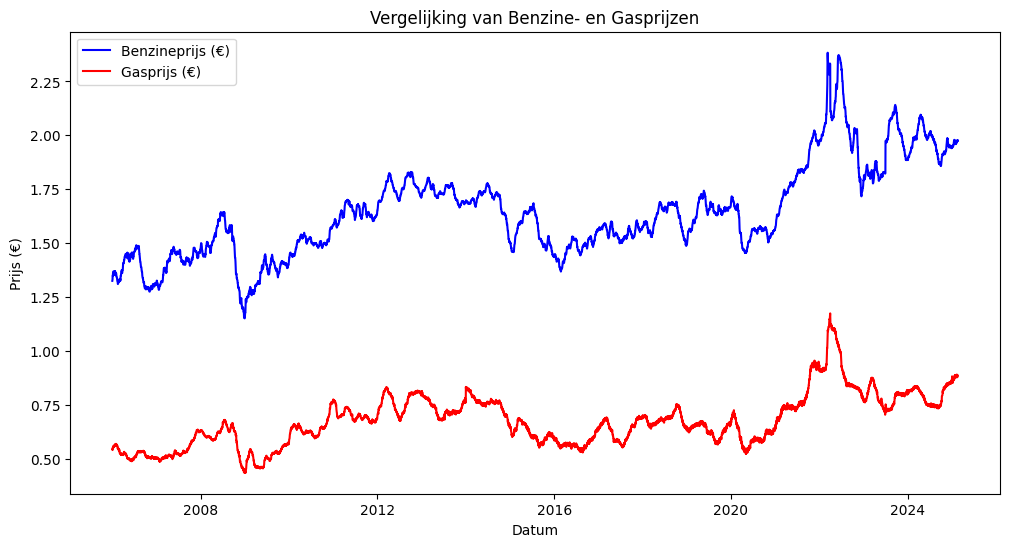

In [4]:
plt.figure(figsize=(12,6))
plt.plot(df["Datum"], df["Benzineprijs"], label="Benzineprijs (€)", color="blue")
plt.plot(df["Datum"], df["Gasprijs"], label="Gasprijs (€)", color="red")
plt.xlabel("Datum")
plt.ylabel("Prijs (€)")
plt.title("Vergelijking van Benzine- en Gasprijzen")
plt.legend()
plt.show()

**4. Train/test split - Verwijder 2021-2025 voor voorspellingen**

In [5]:
df_train = df[df["Datum"] < "2021-01-01"]
df_test = df[df["Datum"] >= "2021-01-01"]

**4. LSTM-model trainen en voorspellen (het algoritme)**

mini neuraal netwerk (Long Short-Term Memory) = goed in voorspellen van patronen in data die in de tijd veranderen

* Invoegen data
* Model bouwen
* Model trainen

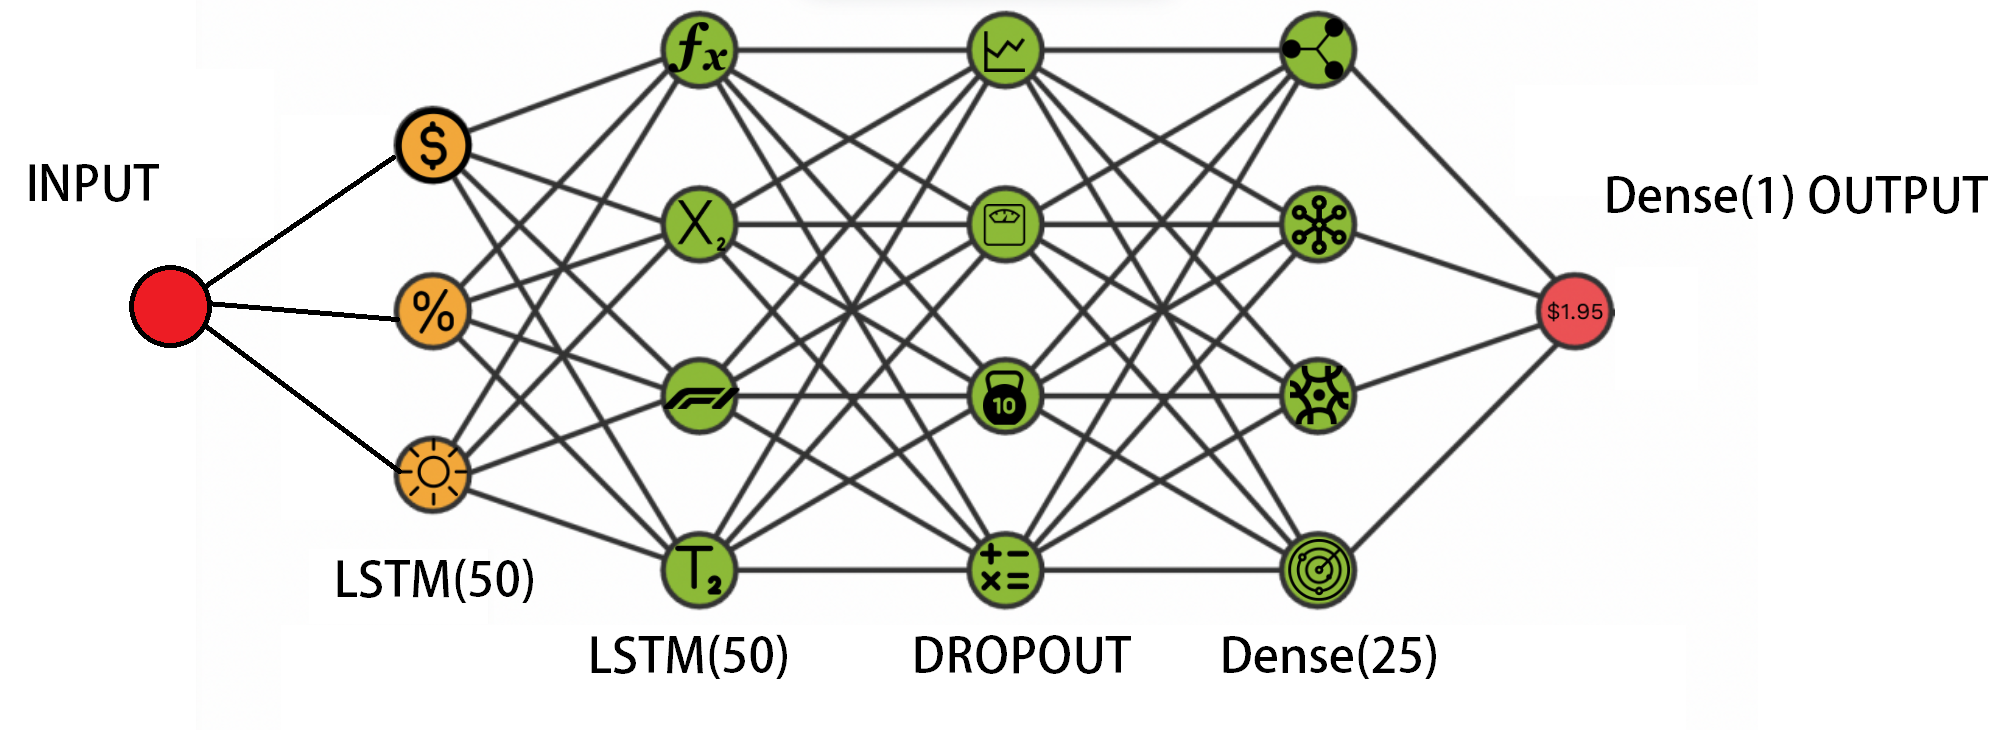

In [14]:
image_path = "../pictures/netwerk1.png"
display(Image(filename=image_path))

In [7]:
window_size = 730 # aantal dagen dat het model data gaat gebruiken= tijdstappen

def create_sequences(data, window_size):
    sequences, labels = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data[i+window_size])
    return np.array(sequences), np.array(labels)

# Voeg inputdata voor model toe door omzetten naar numpy array
price_series_benzine = df_train["Benzineprijs"].values.reshape(-1, 1)
X_benzine, y_benzine = create_sequences(price_series_benzine, window_size)

price_series_gas = df_train["Gasprijs"].values.reshape(-1, 1)
X_gas, y_gas = create_sequences(price_series_gas, window_size)

# Bouw LSTM-model
def build_lstm_model():
    model = Sequential([
        #laag 1:
        LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        #laag 2:
        LSTM(50, return_sequences=False),
        Dropout(0.2), 
        #laag 3:
        Dense(25, activation="relu"),
        #laag 4:
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# EarlyStopping om training te stoppen als de loss niet meer verbetert
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train modellen met EarlyStopping en Dropout
model_lstm_benzine = build_lstm_model()
history_benzine = model_lstm_benzine.fit(
    X_benzine, y_benzine, 
    epochs=10, batch_size=32, verbose=1, validation_split=0.1,
    callbacks=[early_stopping]
)

model_lstm_gas = build_lstm_model()
history_gas = model_lstm_gas.fit(
    X_gas, y_gas, 
    epochs=10, batch_size=32, verbose=1, validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/10
134/134 [==============================] - 55s 369ms/step - loss: 0.1107 - val_loss: 0.0028
Epoch 2/10
134/134 [==============================] - 47s 351ms/step - loss: 0.0178 - val_loss: 9.9241e-04
Epoch 3/10
134/134 [==============================] - 47s 347ms/step - loss: 0.0139 - val_loss: 0.0101
Epoch 4/10
134/134 [==============================] - 47s 349ms/step - loss: 0.0114 - val_loss: 0.0047
Epoch 1/10
134/134 [==============================] - 54s 366ms/step - loss: 0.0141 - val_loss: 2.3595e-04
Epoch 2/10
134/134 [==============================] - 48s 357ms/step - loss: 0.0024 - val_loss: 2.2488e-04
Epoch 3/10
134/134 [==============================] - 48s 355ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/10
134/134 [==============================] - 47s 352ms/step - loss: 0.0015 - val_loss: 2.0905e-04
Epoch 5/10
134/134 [==============================] - 47s 354ms/step - loss: 0.0012 - val_loss: 4.5279e-04
Epoch 6/10
134/134 [==============================] -

In [15]:
print("Aantal datapunten in df_train:", len(df_train))
print("Aantal benzineprijzen:", df_train['Benzineprijs'].dropna().shape[0])
print("Aantal sequences (X_benzine):", X_benzine.shape[0])
print("Aantal trainingsbatches (verwacht):", int((X_benzine.shape[0] * 0.9) / 32))

Aantal datapunten in df_train: 5479
Aantal benzineprijzen: 5479
Aantal sequences (X_benzine): 4749
Aantal trainingsbatches (verwacht): 133


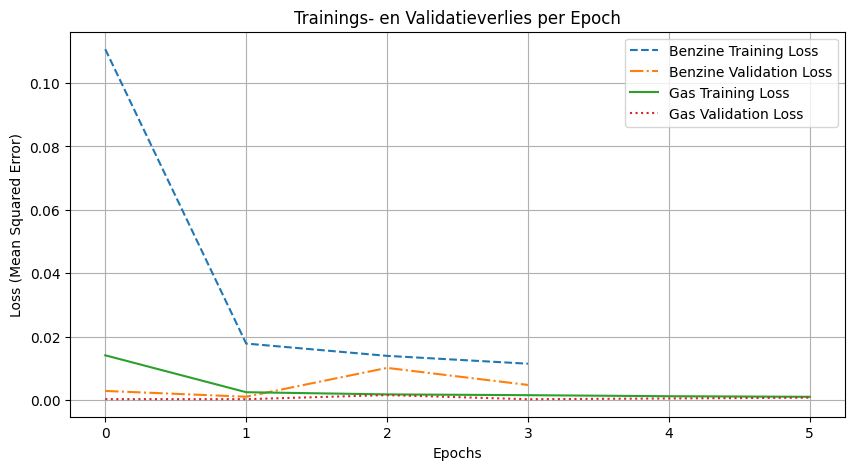

In [16]:
# Plot trainingsverlies per epoch
plt.figure(figsize=(10,5))
plt.plot(history_benzine.history['loss'], label="Benzine Training Loss", linestyle='--')
plt.plot(history_benzine.history['val_loss'], label="Benzine Validation Loss", linestyle='-.')
plt.plot(history_gas.history['loss'], label="Gas Training Loss", linestyle='-')
plt.plot(history_gas.history['val_loss'], label="Gas Validation Loss", linestyle=':')
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean Squared Error)")
plt.title("Trainings- en Validatieverlies per Epoch")
plt.legend()
plt.grid(True)
plt.show()

**5. Voorspellingen genereren voor 2021-2025**

In [17]:
future_months = 12 * 5  # 5 jaar vooruit = 60 maanden
future_steps = future_months

future_steps = future_months
tf.get_logger().setLevel('ERROR')

def predict_future(model, last_window, steps):
    predictions = []
    current_window = last_window.copy()
    
    for _ in range(steps):
        with tf.device('/CPU:0'):
            prediction = model.predict(current_window.reshape(1, window_size, 1), verbose=0)[0][0]
        
        predictions.append(prediction)
        current_window = np.append(current_window[1:], prediction).reshape(window_size, 1)
    
    return np.array(predictions)

last_window_benzine = price_series_benzine[-window_size:]
last_window_gas = price_series_gas[-window_size:]

future_benzine = predict_future(model_lstm_benzine, last_window_benzine, future_steps)
future_gas = predict_future(model_lstm_gas, last_window_gas, future_steps)

**6. Voorspellingen opslaan en visualiseren**

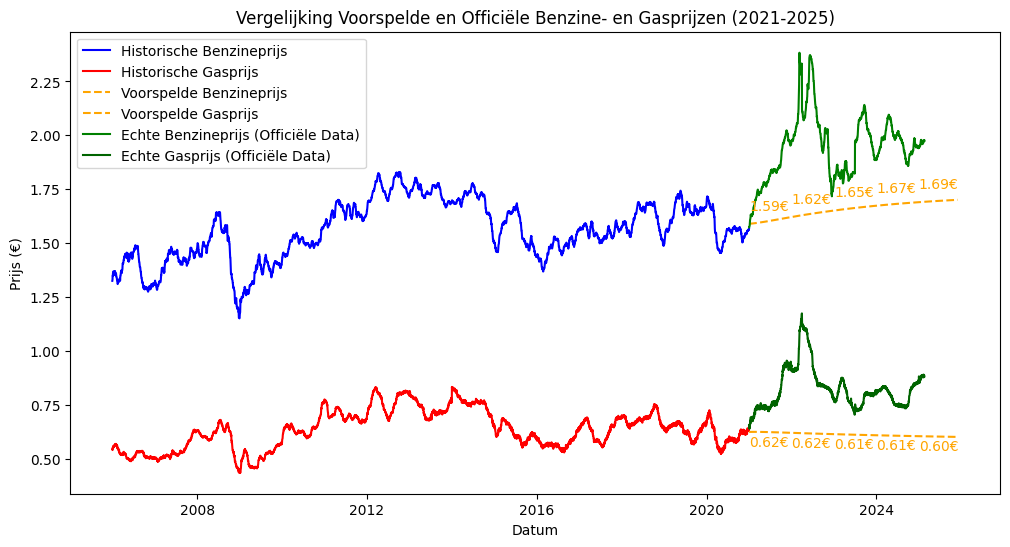

In [18]:
start_date = pd.to_datetime("2021-01-01")
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='MS')

future_df = pd.DataFrame({
    "Datum": future_dates,
    "Voorspelde Benzineprijs (€)": future_benzine,
    "Voorspelde Gasprijs (€)": future_gas
})
future_df.set_index("Datum", inplace=True)

plt.figure(figsize=(12,6))

plt.plot(df_train["Datum"], df_train["Benzineprijs"], label="Historische Benzineprijs", color="blue")
plt.plot(df_train["Datum"], df_train["Gasprijs"], label="Historische Gasprijs", color="red")

plt.plot(future_df.index, future_df["Voorspelde Benzineprijs (€)"], label="Voorspelde Benzineprijs", color="orange", linestyle="dashed")
plt.plot(future_df.index, future_df["Voorspelde Gasprijs (€)"], label="Voorspelde Gasprijs", color="orange", linestyle="dashed")

plt.plot(df_test["Datum"], df_test["Benzineprijs"], label="Echte Benzineprijs (Officiële Data)", color="green", linestyle="solid")
plt.plot(df_test["Datum"], df_test["Gasprijs"], label="Echte Gasprijs (Officiële Data)", color="darkgreen", linestyle="solid")

for year in range(2021, 2026):
    if year in future_df.index.year:
        year_data = future_df.loc[future_df.index.year == year]
        first_entry = year_data.iloc[0]  # Eerste waarde van dat jaar
        
        # Benzineprijs-label met extra padding omhoog
        plt.text(first_entry.name, first_entry["Voorspelde Benzineprijs (€)"] + 0.05, 
                 f"{first_entry['Voorspelde Benzineprijs (€)']:.2f}€", 
                 verticalalignment='bottom', color="orange", fontsize=10)
        
        # Gasprijs-label met extra padding omhoog
        plt.text(first_entry.name, first_entry["Voorspelde Gasprijs (€)"] - 0.08, 
                 f"{first_entry['Voorspelde Gasprijs (€)']:.2f}€", 
                 verticalalignment='bottom', color="orange", fontsize=10)

plt.xlabel("Datum")
plt.ylabel("Prijs (€)")
plt.title("Vergelijking Voorspelde en Officiële Benzine- en Gasprijzen (2021-2025)")
plt.legend()
plt.show()
